# Deep Learning for NLP - Project

RULES:

* Do not create any additional cell

* Fill in the blanks

* All cells should be runnable (modulo trivial compatibility bugs that we'd fix)

* 4 / 20 points will be allocated to the clarity of your code

* Efficient code will have a bonus

DELIVERABLE:

* this notebook
* the predictions of the SST test set

DO NOT INCLUDE THE DATASETS IN THE DELIVERABLE..

In [1]:
import io
import os
import numpy as np
import scipy
from sklearn.linear_model import LogisticRegression
from sklearn import metrics
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import LinearSVC
import matplotlib.pyplot as plt

In [2]:
PATH_TO_DATA = r"C:/Users/assae/Documents/Cours CS/3A/OMA/Deep learning/Deep Learning MVA/MVA_MP2/nlp_project/data/"

# 1) Monolingual (English) word embeddings 

In [6]:
class Word2vec():
    def __init__(self, fname, nmax=100000):
        self.load_wordvec(fname, nmax)
        self.word2id = dict.fromkeys(self.word2vec.keys())
        self.id2word = {v: k for k, v in self.word2id.items()}
        self.embeddings = np.array(self.word2vec.values())
    
    def load_wordvec(self, fname, nmax):
        self.word2vec = {}
        with io.open(fname, encoding='utf-8') as f:
            next(f)
            for i, line in enumerate(f):
                word, vec = line.split(' ', 1)
                word = word.lower()
                self.word2vec[word] = np.fromstring(vec, sep=' ')
                if i == (nmax - 1):
                    break
        print('Loaded %s pretrained word vectors' % (len(self.word2vec)))

    def most_similar(self, w, K=5):
        # K most similar words: self.score  -  np.argsort 
        score_list = np.array([])
        keys  = list(self.word2vec.keys())
        
        for word in keys:
            score_list = np.concatenate((score_list, [self.score(w, word)]), axis=0)
        
        # we take the opposite of each value, which allow us to sort sorted_index in reverse order 
        # (all valuesof score_list are between 0 and 1
        sorted_index = np.argsort(-score_list)
        knn = []
        for j in range(1,K+1):
            knn.append(keys[sorted_index[j]])    
        return knn

    def score(self, w1, w2):
        # cosine similarity: np.dot  -  np.linalg.norm
        v1 = self.word2vec[w1]
        v2 = self.word2vec[w2]
        cos_sim = np.dot(v1, v2) / (np.linalg.norm(v1)*np.linalg.norm(v2))
        return cos_sim


In [4]:
w2v = Word2vec(os.path.join(PATH_TO_DATA, 'crawl-300d-200k.vec'), nmax=25000)

# You will be evaluated on the output of the following:
for w1, w2 in zip(('cat', 'dog', 'dogs', 'paris', 'germany'), ('dog', 'pet', 'cats', 'france', 'berlin')):
    print("Similarity between", w1, "and", w2, ":" , w2v.score(w1, w2))
print("\n")
for w1 in ['cat', 'dog', 'dogs', 'paris', 'germany']:
    print(w1, "is most similar to the words in", w2v.most_similar(w1))

Loaded 19765 pretrained word vectors
Similarity between cat and dog : 0.2510936879670139
Similarity between dog and pet : 0.28149744895768625
Similarity between dogs and cats : 0.6747577573530962
Similarity between paris and france : 0.7058595452409975
Similarity between germany and berlin : 0.7060253015336013


cat is most similar to the words in ['man', 'sat', 'pet', 'act', 'star']
dog is most similar to the words in ['dogs', 'puppy', 'canine', 'horse', 'pets']
dogs is most similar to the words in ['dog', 'pets', 'cats', 'animals', 'horses']
paris is most similar to the words in ['parisian', 'france', 'versailles', 'lyon', 'bordeaux']
germany is most similar to the words in ['austria', 'bavaria', 'berlin', 'munich', 'hamburg']


In [7]:
class BoV():
    def __init__(self, w2v):
        self.w2v = w2v
    
    def encode(self, sentences, idf=False):
        # takes a list of sentences, outputs a numpy array of sentence embeddings
        # see TP1 for help
        sentemb = []
        
        for sent in sentences:
            if idf is False:
                # mean of word vectors
                list_w_emb = []
                for w in set(sent.split()):
                    list_w_emb.append(self.w2v.word2vec.get(w, np.zeros((300,))))
                sum_v = 0
                for v in list_w_emb:
                    sum_v += v
                sentemb.append(sum_v/len(list_w_emb))
                
            else:
                # idf-weighted mean of word vectors
                list_w_emb = []
                for w in set(sent.split()):
                    list_w_emb.append(np.dot(self.w2v.word2vec.get(w, np.zeros((300,))), idf.get(w, 0)))
                sum_v = 0
                for v in list_w_emb:
                    sum_v += v
                sentemb.append(sum_v/len(list_w_emb))
        return np.vstack(sentemb)

    def most_similar(self, s, sentences, idf=False, K=5):
        # get most similar sentences and **print** them
        keys = self.encode(sentences, idf)
        query = self.encode([s], idf)
        
        score_list = np.array([])
        
        for i in range(len(keys)):
            score_list = np.concatenate((score_list, [self.score(s, sentences[i], idf)]), axis=0)
        
        # we take the opposite of each value, which allow us to sort sorted_index in reverse order 
        # (all valuesof score_list are between 0 and 1
        sorted_index = np.argsort(-score_list)
        knn = []
        for j in range(1, K+1):
            knn.append(sentences[sorted_index[j]])    
        return knn

    def score(self, s1, s2, idf=False):
        # cosine similarity: use   np.dot  and  np.linalg.norm
        v1 = self.encode([s1], idf)[0]
        v2 = self.encode([s2], idf)[0]
        cos_sim = np.dot(v1, v2) / (np.linalg.norm(v1)*np.linalg.norm(v2))
        return cos_sim
    
    def build_idf(self, sentences):
        # build the idf dictionary: associate each word to its idf value
        idf = {}
        for sent in sentences:
            for w in set(sent.split()):
                idf[w] = idf.get(w, 0) + 1
        for word in list(idf.keys()):
            idf[word] = max(1, np.log10(len(sentences) / (idf[word])))
        return idf


In [6]:
w2v = Word2vec(os.path.join(PATH_TO_DATA, 'crawl-300d-200k.vec'), nmax=5000)
s2v = BoV(w2v)


# Load sentences in "PATH_TO_DATA/sentences.txt"
with io.open(os.path.join(PATH_TO_DATA, 'sentences.txt'), encoding='utf-8') as f:
    sentences = list(f)

    

no_idf = True   
print("Mean model \n")
# Build idf scores for each word
idf = {} if no_idf else s2v.build_idf(sentences)
# You will be evaluated on the output of the following:
print('' if not sentences else sentences[10], "Similar to the sentences in:", s2v.most_similar('' if not sentences else sentences[10], sentences))  # BoV-mean
print("\n")
print("Similarity between: \n", '' if not sentences else sentences[7], '' if not sentences else sentences[13], s2v.score('' if not sentences else sentences[7], '' if not sentences else sentences[13]))


no_idf = False
print("\n")
print("\n")
print("IDF model \n")
idf = {} if no_idf else s2v.build_idf(sentences) 
print('' if not sentences else sentences[10], "Similar to the sentences in:", s2v.most_similar('' if not sentences else sentences[10], sentences, idf))  # BoV-idf
print("\n")
print("Similarity between: \n", '' if not sentences else sentences[7], '' if not sentences else sentences[13], s2v.score('' if not sentences else sentences[7], '' if not sentences else sentences[13], idf))

Loaded 4367 pretrained word vectors
Mean model 



C:\Users\assae\Anaconda3\lib\site-packages\ipykernel_launcher.py:54: RuntimeWarning: invalid value encountered in double_scalars


1 smiling african american boy . 
 Similar to the sentences in: ['an african american man smiling . \n', 'african american female in a gray dress . \n', 'african american woman bouncing black basketball \n', 'an african american male holding a microphone . \n', 'an african american man playing a saxophone . \n']


Similarity between: 
 1 man singing and 1 man playing a saxophone in a concert . 
 10 people venture out to go crosscountry skiing . 
 0.5505701983202919




IDF model 

1 smiling african american boy . 
 Similar to the sentences in: ['an african american man smiling . \n', 'an african american man playing a saxophone . \n', 'an african american man is sitting . \n', 'african american woman bouncing black basketball \n', 'an african american in sunglasses and a white tee-shirt smiles . \n']


Similarity between: 
 1 man singing and 1 man playing a saxophone in a concert . 
 10 people venture out to go crosscountry skiing . 
 0.5246814806185796


# 2) Multilingual (English-French) word embeddings

Let's consider a bilingual dictionary of size V_a (e.g French-English).

Let's define **X** and **Y** the **French** and **English** matrices.

They contain the embeddings associated to the words in the bilingual dictionary.

We want to find a **mapping W** that will project the source word space (e.g French) to the target word space (e.g English).

Procrustes : **W\* = argmin || W.X - Y ||  s.t  W^T.W = Id**
has a closed form solution:
**W = U.V^T  where  U.Sig.V^T = SVD(Y.X^T)**

In what follows, you are asked to: 

In [7]:
# 1 - Download and load 50k first vectors of
#     https://s3-us-west-1.amazonaws.com/fasttext-vectors/wiki.en.vec
#     https://s3-us-west-1.amazonaws.com/fasttext-vectors/wiki.fr.vec

# TYPE CODE HERE

english_dict = {}
f = io.open(os.path.join(PATH_TO_DATA, 'wiki.en.vec'), encoding='utf-8')
next(f)
line = f.readline()
i = 0
while line and i<50000:
    i+=1
    sl = line.split(' ', 1)
    english_dict[sl[0]] = [float(x) for x in sl[1].split(' ')[0:300]]
    line = f.readline()
f.close()

        
french_dict = {}
f = io.open(os.path.join(PATH_TO_DATA, 'wiki.fr.vec'), encoding='utf-8')
next(f)
line = f.readline()
i = 0
while line and i<50000:
    i+=1
    sl = line.split(' ', 1)
    french_dict[sl[0]] = [float(x) for x in sl[1].split(' ')[0:300]]
    line = f.readline()
f.close()

In [8]:
# 2 - Get words that appear in both vocabs (= identical character strings)
#     Use it to create the matrix X and Y (of aligned embeddings for these words)

# TYPE CODE HERE

identics = set(french_dict.keys()).intersection(set(english_dict.keys()))
    
X = []
Y = []
for word in identics:
    X.append(french_dict[word])
    Y.append(english_dict[word])
    
X = np.transpose(np.vstack(X))
Y = np.transpose(np.vstack(Y))

In [9]:
# 3 - Solve the Procrustes using the scipy package and: scipy.linalg.svd() and get the optimal W
#     Now W*French_vector is in the same space as English_vector

# TYPE CODE HERE

U, s, Vh = scipy.linalg.svd(np.dot(Y, np.transpose(X)))
W = np.dot(U, Vh)

In [10]:
# 4 - After alignment with W, give examples of English nearest neighbors of some French words (and vice versa)
#     You will be evaluated on that part and the code above

# TYPE CODE HERE

def score(v1, v2):
    cos_sim = np.dot(v1, v2) / (np.linalg.norm(v1)*np.linalg.norm(v2))
    return cos_sim


### French to English

french_word = 'louer'
nb_closed_words_desired = 10

french_emb = french_dict[french_word]
english_emb = np.dot(W, np.transpose(french_emb))

english_closest_traductions = []
scores = []
eng_key_emb = list(english_dict.keys())
eng_val_emb = list(english_dict.values())
for i in range(len(eng_val_emb)):
    scores.append(score(english_emb, eng_val_emb[i]))
scores = np.array(scores)
sorted_index = np.argsort(-scores)

for j in range(nb_closed_words_desired):
    english_closest_traductions.append(eng_key_emb[sorted_index[j]])
    
print(french_word, "\n Closest traductions in English:", english_closest_traductions)


print("\n")
### English to French

english_word = 'rent'
nb_closed_words_desired = 10

english_emb = english_dict[english_word]
french_emb = np.dot(np.transpose(W), np.transpose(english_emb))

french_closest_traductions = []
scores = []
fr_key_emb = list(french_dict.keys())
fr_val_emb = list(french_dict.values())
for i in range(len(fr_val_emb)):
    scores.append(score(french_emb, fr_val_emb[i]))
scores = np.array(scores)
sorted_index = np.argsort(-scores)

for j in range(nb_closed_words_desired):
    french_closest_traductions.append(fr_key_emb[sorted_index[j]])
    
print(english_word, "\n Closest traductions in French:", french_closest_traductions)


louer 
 Closest traductions in English: ['renting', 'rented', 'lodging', 'accommodations', 'rents', 'rent', 'hire', 'lodgings', 'rental', 'lease']


rent 
 Closest traductions in French: ['loyer', 'locations', 'locataire', 'locataires', 'loyers', 'louer', 'taxation', 'payer', 'taxes', 'remboursement']


If you want to dive deeper on this subject: https://github.com/facebookresearch/MUSE

# 3) Sentence classification with BoV and scikit-learn

In [139]:
# 1 - Load train/dev/test of Stanford Sentiment TreeBank (SST)
#     (https://nlp.stanford.edu/~socherr/EMNLP2013_RNTN.pdf)



# TYPE CODE HERE

sentences_train = []
sentences_train_label = []
with io.open(os.path.join(PATH_TO_DATA, 'SST/stsa.fine.train'), encoding='utf-8') as f:
    for line in f: 
        sentences_train.append(line.split(' ', 1)[1])
        sentences_train_label.append(int(line.split(' ', 1)[0]))
        
sentences_dev = []
sentences_dev_label = []
with io.open(os.path.join(PATH_TO_DATA, 'SST/stsa.fine.dev'), encoding='utf-8') as f:
    for line in f: 
        sentences_dev.append(line.split(' ', 1)[1])
        sentences_dev_label.append(int(line.split(' ', 1)[0]))


with io.open(os.path.join(PATH_TO_DATA, 'SST/stsa.fine.test'), encoding='utf-8') as f:
    sentences_test = list(f)

In [12]:
# 2 - Encode sentences with the BoV model above

# TYPE CODE HERE

w2v = Word2vec(os.path.join(PATH_TO_DATA, 'crawl-300d-200k.vec'), nmax=25000)
s2v = BoV(w2v)

#without idf - mean

encode_sentences_train_mean = s2v.encode(sentences_train)
encode_sentences_dev_mean = s2v.encode(sentences_dev)
encode_sentences_test_mean = s2v.encode(sentences_test)

# with idf

sentences = []
for sent in np.concatenate(([*sentences_train], [*sentences_dev], [*sentences_test])): 
    sentences.append(sent)
    
idf = s2v.build_idf(sentences)

encode_sentences_train_idf = s2v.encode(sentences_train, idf)
encode_sentences_dev_idf = s2v.encode(sentences_dev, idf)
encode_sentences_test_idf = s2v.encode(sentences_test, idf)

Loaded 19765 pretrained word vectors


In [13]:
# 3 - Learn Logistic Regression on top of sentence embeddings using scikit-learn
#     (consider tuning the L2 regularization on the dev set)

# TYPE CODE HERE


#without idf - mean

clf_mean = LogisticRegression(penalty='l2', solver='lbfgs', max_iter=500, multi_class='multinomial', C=1.27)
clf_mean.fit(encode_sentences_train_mean, np.array(sentences_train_label))

score = clf_mean.score(encode_sentences_train_mean, np.array(sentences_train_label))
print('SCORE_Training_Set_Mean', score)
score = clf_mean.score(encode_sentences_dev_mean, np.array(sentences_dev_label))
print('SCORE_Dev_Set_Mean', score)


# with idf

clf_idf = LogisticRegression(penalty='l2', solver='lbfgs', max_iter=500, multi_class='multinomial', C=0.04)
clf_idf.fit(encode_sentences_train_idf, np.array(sentences_train_label))

score = clf_idf.score(encode_sentences_train_idf, np.array(sentences_train_label))
print('SCORE_Training_Set_IDF', score)
score = clf_idf.score(encode_sentences_dev_idf, np.array(sentences_dev_label))
print('SCORE_Dev_Set_IDF', score)

SCORE_Training_Set_Mean 0.4666432584269663
SCORE_Dev_Set_Mean 0.40236148955495005
SCORE_Training_Set_IDF 0.44335205992509363
SCORE_Dev_Set_IDF 0.3932788374205268


In [14]:
# 4 - Produce 2210 predictions for the test set (in the same order). One line = one prediction (=0,1,2,3,4).
#     Attach the output file "logreg_bov_y_test_sst.txt" to your deliverable.
#     You will be evaluated on the results of the test set.

# TYPE CODE HERE

#The best score on the dev set is obtained whith the Mean model. We are making predictions using this model.

predictions_test = []
f = io.open(os.path.join(PATH_TO_DATA, 'SST/logreg_bov_y_test_sst.txt'),'w')
for i in range(len(encode_sentences_test_mean)):
    predictions_test.append(clf_mean.predict(encode_sentences_test_mean[i:i+1])[0])
    f.write(str(predictions_test[i]) + "\n")
f.close()
    

In [15]:
# BONUS!
# 5 - Try to improve performance with another classifier
#     Attach the output file "XXX_bov_y_test_sst.txt" to your deliverable (where XXX = the name of the classifier)

# TYPE CODE HERE


#without idf - mean

# the trials gave worse results using idf. It is a minor improvement comparing to the results with the logistic regression.

clfsvm_mean = LinearSVC(C=0.05)
clfsvm_mean.fit(encode_sentences_train_mean, np.array(sentences_train_label))

score = clfsvm_mean.score(encode_sentences_train_mean, np.array(sentences_train_label))
print('SCORE_Training_Set_Mean', score)
score = clfsvm_mean.score(encode_sentences_dev_mean, np.array(sentences_dev_label))
print('SCORE_Dev_Set_Mean', score)


predictions_test = []
f = io.open(os.path.join(PATH_TO_DATA, 'SST/svm_bov_y_test_sst.txt'),'w')
for i in range(len(encode_sentences_test_mean)):
    predictions_test.append(clfsvm_mean.predict(encode_sentences_test_mean[i:i+1])[0])
    f.write(str(predictions_test[i]) + "\n")
f.close()

SCORE_Training_Set_Mean 0.45657771535580527
SCORE_Dev_Set_Mean 0.40417801998183467


# 4) Sentence classification with LSTMs in Keras

## 4.1 - Preprocessing

In [4]:
import keras

In [140]:
# 1 - Load train/dev/test sets of SST
PATH_TO_DATA = r"C:/Users/assae/Documents/Cours CS/3A/OMA/Deep learning/Deep Learning MVA/MVA_MP2/nlp_project/data/"

# TYPE CODE HERE

sentences_train = []
sentences_train_label = []
with io.open(os.path.join(PATH_TO_DATA, 'SST/stsa.fine.train'), encoding='utf-8') as f:
    for line in f: 
        sentences_train.append(line.split(' ', 1)[1])
        sentences_train_label.append(int(line.split(' ', 1)[0]))
y_train = keras.utils.to_categorical(sentences_train_label)
size_train = len(sentences_train)

sentences_dev = []
sentences_dev_label = []
with io.open(os.path.join(PATH_TO_DATA, 'SST/stsa.fine.dev'), encoding='utf-8') as f:
    for line in f: 
        sentences_dev.append(line.split(' ', 1)[1])
        sentences_dev_label.append(int(line.split(' ', 1)[0]))
y_dev = keras.utils.to_categorical(sentences_dev_label)
size_dev = len(sentences_dev)
        
with io.open(os.path.join(PATH_TO_DATA, 'SST/stsa.fine.test'), encoding='utf-8') as f:
    sentences_test = list(f)
size_test = len(sentences_test)

In [125]:
# 2 - Transform text to integers using keras.preprocessing.text.one_hot function
#     https://keras.io/preprocessing/text/

# TYPE CODE HERE

encode_sentences_total = []

for sent in np.concatenate(([*sentences_train], [*sentences_dev], [*sentences_test])): 
    encode_sentences_total.append(keras.preprocessing.text.one_hot(sent, 25000))
    

**Padding input data**

Models in Keras (and elsewhere) take batches of sentences of the same length as input. It is because Deep Learning framework have been designed to handle well Tensors, which are particularly suited for fast computation on the GPU.

Since sentences have different sizes, we "pad" them. That is, we add dummy "padding" tokens so that they all have the same length.

The input to a Keras model thus has this size : (batchsize, maxseqlen) where maxseqlen is the maximum length of a sentence in the batch.

In [126]:
# 3 - Pad your sequences using keras.preprocessing.sequence.pad_sequences
#     https://keras.io/preprocessing/sequence/

# TYPE CODE HERE

pad_encode_sentences_total = keras.preprocessing.sequence.pad_sequences(encode_sentences_total)

x_train = pad_encode_sentences_total[0:size_train]
x_dev = pad_encode_sentences_total[size_train:size_train+size_dev]
x_test = pad_encode_sentences_total[size_train+size_dev:]

## 4.2 - Design and train your model

In [127]:
# 4 - Design your encoder + classifier using keras.layers
#     In Keras, Torch and other deep learning framework, we create a "container" which is the Sequential() module.
#     Then we add components to this contained : the lookuptable, the LSTM, the classifier etc.
#     All of these components are contained in the Sequential() and are trained together.


# ADAPT CODE BELOW


from keras.models import Sequential
from keras.layers import Embedding, LSTM, Dense, Activation

embed_dim  = 52  # word embedding dimension
nhid       = 128  # number of hidden units in the LSTM
vocab_size = 25000  # size of the vocabulary
n_classes  = 5

model = Sequential()
model.add(Embedding(vocab_size, embed_dim))
model.add(LSTM(nhid, dropout=0.2, recurrent_dropout=0.2))
model.add(Dense(n_classes, activation='softmax'))


In [99]:
# 5 - Define your loss/optimizer/metrics

# MODIFY CODE BELOW

loss_classif     =  'categorical_crossentropy' # find the right loss for multi-class classification
optimizer        =  'adam' # find the right optimizer
metrics_classif  =  ['accuracy']

# Observe how easy (but blackboxed) this is in Keras
model.compile(loss=loss_classif,
              optimizer=optimizer,
              metrics=metrics_classif)
print(model.summary())

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_12 (Embedding)     (None, None, 52)          1300000   
_________________________________________________________________
lstm_12 (LSTM)               (None, 128)               92672     
_________________________________________________________________
dense_12 (Dense)             (None, 5)                 645       
Total params: 1,393,317
Trainable params: 1,393,317
Non-trainable params: 0
_________________________________________________________________
None


Train on 8544 samples, validate on 1101 samples
Epoch 1/2
8544/8544 [==============================] - 28s 3ms/step - loss: 1.5653 - acc: 0.2849 - val_loss: 1.5458 - val_acc: 0.2761
Epoch 2/2
8544/8544 [==============================] - 25s 3ms/step - loss: 1.3793 - acc: 0.4046 - val_loss: 1.3950 - val_acc: 0.3760


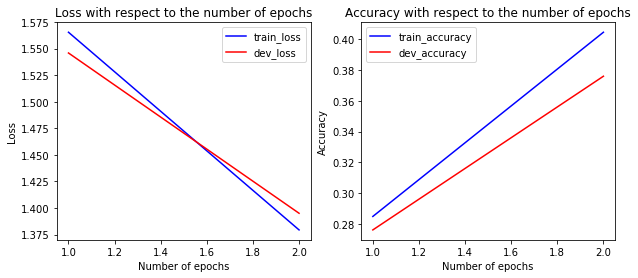

In [100]:
# 6 - Train your model and find the best hyperparameters for your dev set
#     you will be evaluated on the quality of your predictions on the test set

# ADAPT CODE BELOW
bs = 64
n_epochs = 2
#Trial with more epochs have been made to show the network overfitting as it is trained 
#(showed on the graphs below if we increase the number of epochs)
 

history = model.fit(x_train, y_train, batch_size=bs, epochs=n_epochs, validation_data=(x_dev, y_dev))


#PLots of loss and accuracy with respect to the number of epochs
plt.subplots(1,2,figsize=(10,4))
plt.subplot(121)
plt.plot(range(1,n_epochs+1), history.history["loss"], 'b', label='train_loss')
plt.plot(range(1,n_epochs+1), history.history["val_loss"], 'r', label='dev_loss')
plt.xlabel("Number of epochs")
plt.ylabel("Loss")
plt.title("Loss with respect to the number of epochs")
plt.legend()
plt.subplot(122)
plt.plot(range(1,n_epochs+1), history.history["acc"], 'b', label='train_accuracy')
plt.plot(range(1,n_epochs+1), history.history["val_acc"], 'r',label='dev_accuracy')
plt.xlabel("Number of epochs")
plt.ylabel("Accuracy")
plt.title("Accuracy with respect to the number of epochs")
plt.legend()

In [105]:
# 7 - Generate your predictions on the test set using model.predict(x_test)
#     https://keras.io/models/model/
#     Log your predictions in a file (one line = one integer: 0,1,2,3,4)
#     Attach the output file "logreg_lstm_y_test_sst.txt" to your deliverable.

# TYPE CODE HERE

predictions = model.predict(x_test)

f = io.open(os.path.join(PATH_TO_DATA, 'SST/logreg_lstm_y_test_sst.txt'),'w')
for i in range(len(predictions)):
        f.write(str(np.argmax(predictions[i])) + "\n")
f.close()


## 4.3 -- innovate !

In [8]:
# 8 - Open question: find a model that is better on your dev set
#     (e.g: use a 1D ConvNet, use a better classifier, pretrain your lookup tables ..)
#     you will get point if the results on the test set are better: be careful of not overfitting your dev set too much..
#     Attach the output file "XXX_XXX_y_test_sst.txt" to your deliverable.

# TYPE CODE HERE
PATH_TO_DATA = r"C:/Users/assae/Documents/Cours CS/3A/OMA/Deep learning/Deep Learning MVA/MVA_MP2/nlp_project/data/"

from keras.models import Sequential
from keras.layers import Embedding, LSTM, Dense, Activation, Conv1D, Flatten, Dropout, MaxPooling1D



### Loading the data ###

x_train = []
sentences_train_label = []
with io.open(os.path.join(PATH_TO_DATA, 'SST/stsa.fine.train'), encoding='utf-8') as f:
    for line in f: 
        x_train.append(line.split(' ', 1)[1])
        sentences_train_label.append(int(line.split(' ', 1)[0]))
y_train = keras.utils.to_categorical(sentences_train_label)
size_train = len(x_train)

x_dev = []
sentences_dev_label = []
with io.open(os.path.join(PATH_TO_DATA, 'SST/stsa.fine.dev'), encoding='utf-8') as f:
    for line in f: 
        x_dev.append(line.split(' ', 1)[1])
        sentences_dev_label.append(int(line.split(' ', 1)[0]))
y_dev = keras.utils.to_categorical(sentences_dev_label)
size_dev = len(x_dev)
        
with io.open(os.path.join(PATH_TO_DATA, 'SST/stsa.fine.test'), encoding='utf-8') as f:
    x_test = list(f)
size_test = len(x_test)



### Encoding our data with the BoV model using IDF-weighted average ###

w2v = Word2vec(os.path.join(PATH_TO_DATA, 'crawl-300d-200k.vec'), nmax=25000)
s2v = BoV(w2v)

sentences = []
for sent in np.concatenate(([*x_train], [*x_dev], [*x_test])): 
    sentences.append(sent)
    
idf = s2v.build_idf(sentences)

x_train = s2v.encode(x_train, idf)
x_dev = s2v.encode(x_dev, idf)
x_test = s2v.encode(x_test, idf)



### Reshaping our data ###

embed_dim  = 300  # word embedding dimension

x_train = x_train.reshape((size_train, embed_dim, 1))
x_dev = x_dev.reshape((size_dev, embed_dim, 1))
x_test = x_test.reshape((size_test, embed_dim, 1))



### Building and fitting the CNN ###

n_classes  = 5

model = Sequential()
model.add(Conv1D(filters=32, kernel_size=5, activation='relu',input_shape=(embed_dim,1)))
model.add(Flatten())
model.add(Dense(100, activation='sigmoid'))
model.add(Dense(n_classes, activation='softmax'))

loss_classif     =  'categorical_crossentropy' # find the right loss for multi-class classification
optimizer        =  'adam' # find the right optimizer
metrics_classif  =  ['accuracy']

model.compile(loss=loss_classif,
              optimizer=optimizer,
              metrics=metrics_classif)
print(model.summary())

bs = 32
n_epochs = 5
history = model.fit(x_train, y_train, batch_size=bs, epochs=n_epochs, validation_data=(x_dev, y_dev))



### Making the predictions ###
predictions = model.predict(x_test)

f = io.open(os.path.join(PATH_TO_DATA, 'SST/cnn_y_test_sst.txt'),'w')
for i in range(len(predictions)):
        f.write(str(np.argmax(predictions[i])) + "\n")
f.close()

Loaded 19765 pretrained word vectors
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_1 (Conv1D)            (None, 296, 32)           192       
_________________________________________________________________
flatten_1 (Flatten)          (None, 9472)              0         
_________________________________________________________________
dense_1 (Dense)              (None, 100)               947300    
_________________________________________________________________
dense_2 (Dense)              (None, 5)                 505       
Total params: 947,997
Trainable params: 947,997
Non-trainable params: 0
_________________________________________________________________
None
Train on 8544 samples, validate on 1101 samples
Epoch 1/5
8544/8544 [==============================] - 9s 1ms/step - loss: 1.4387 - acc: 0.3604 - val_loss: 1.3691 - val_acc: 0.3688
Epoch 2/5
8544/8544 [========================